<a href="https://colab.research.google.com/github/JINU6497/JINUrepo/blob/master/JINWOO_cifar100_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%matplotlib inline


분류기(Classifier) 학습하기
============================

----------------------------

다음과 같은 단계로 진행해보겠습니다:

1. ``torchvision`` 을 사용하여 CIFAR100의 학습용 / 시험용 데이터셋을
   불러오고, 정규화(nomarlizing)합니다.
2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용하여 신경망을 검사합니다.

1. CIFAR100을 불러오고 정규화하기
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

``torchvision`` 을 사용하여 매우 쉽게 CIFAR100을 불러올 수 있습니다.


In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from google.colab import files
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
FOLDERNAME = "ML"
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다.
이를 [-1, 1]의 범위로 정규화된 Tensor로 변환합니다.

<div class="alert alert-info"><h4>Note</h4><p>만약 Windows 환경에서 BrokenPipeError가 발생한다면,
    torch.utils.data.DataLoader()의 num_worker를 0으로 설정해보세요.</p></div>



In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cuda:0


In [13]:
#transform = transforms.Compose(
#   [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#transform_train = transforms.Compose([
#    transforms.RandomCrop(32, padding=4),
#    transforms.RandomHorizontalFlip(),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
#])

# Normalize test set same as training set without augmentation
#transform_test = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
#])

transform= transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

batch_size = 64

#trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                        download=True, transform=transform)
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                       download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat',
#           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


classes = ('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')

Files already downloaded and verified
Files already downloaded and verified


학습용 이미지 몇 개를 보겠습니다.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


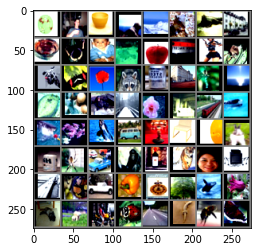

plate   man  bowl  seal   sea mouse lizard house  bowl butterfly  baby flatfish apple train woman mouse motorcycle butterfly poppy raccoon   can castle spider   sea flatfish  pear chimpanzee bridge  rose couch train whale shark orchid whale   bus  lamp chair orange rabbit   can spider pickup_truck chimpanzee bottle tiger woman television  road  bowl pickup_truck sweet_pepper clock oak_tree whale tulip rabbit  bear motorcycle beetle  road lizard   bee butterfly


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

2. 합성곱 신경망(Convolution Neural Network) 정의하기
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
이전의 신경망 섹션에서 신경망을 복사한 후, (기존에 1채널 이미지만 처리하도록
정의된 것을) 3채널 이미지를 처리할 수 있도록 수정합니다.



In [15]:

import torch.nn as nn
import torch.nn.functional as F

#############################ResNet##################################
#class ResNet_Block(nn.Module):
#  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#    super(ResNet_Blcok, self).__init__()  
#
#    self.conv1=nn.Conv2d(in_channels,out_channels, kernel_size=3,stride=stride, padding=1, bias=Flase)
#    self.bn1=nn.BatchNorm2d(out_channels)
#
#    self.conv2=nn.Conv2d(in_channels,out_channels, kernel_size=3, padding=1, bias=Flase)
#    self.bn2=nn.BatchNorm2d(out_channels)
#
#    self.downsample = downsample
#
#  def forward(self, x):
#    shortcut_input=x
#
#    out=F.relu(self.bn1(self.conv1(x)))
#    out=self.bn2(self.conv2(out))
#    
#    if self.downsample:
#        shortcut_input = self.downsample(shortcut_input)
#    
#    out+=shortcut_input
#    
#    return out
#
#class ResNet(nn.Module):
#  def __init__(self, block, layers, num_class=100):
#    super(ResNet, self).__init__()
#
#    self.inChannel=32
#    self.conv1=nn.Conv2d(3,32, kernel_size=3,stride=1, padding=1)
#    self.bn1=nn.BatchNorm2d(32)
#    self.conv1_dol=nn.Dropout(p=0.01)
#
#    self.bl_2=self.make_block_layer(block,32,1,layers[0])
#    self.bl_3=self.make_block_layer(block,64,2,layers[1])
#    self.bl_4=self.make_block_layer(block,128,2,layers[2])
#    self.bl_5=self.make_block_layer(block,256,2,layers[3])
#    
#    self.fc1=nn.Linear(1024,num_class)
#
#  def make_block_layer(self, block, out_channels, stride=1,blocks=2):
#     
#      downsample = None
#      if (stride != 1) or (self.in_channels != out_channels):
#          downsample = nn.Sequential(
#              nn.Conv2d(self.in_channels, out_channels,kernel_size=3, stride=stride, padding=1, bias=False),
#              nn.BatchNorm2d(out_channels)
#          )
#
#      filters = []
#      filters.append(block(self.in_channels, out_channels, stride, downsample))
#      self.in_channels = out_channels
#      for i in range(1, blokcs):
#          filter.append(block(out_channels, out_channels))
#
#      return nn.Sequential(*filters)
#
#  def num_flat_features(self, x):
#    size=x[0].size()
#    num_features=1
#    for s in size:
#      num_features*=s
#    return num_features
#  
#  def forward(self,x):
#    x=self.conv1_dol(F.relu(self.bn1(self.conv1(x))))
#    x=self.bl_2(x)
#    x=self.bl_3(x)
#    x=self.bl_4(x)
#
#    x=F.max_pool2d(self.bl_5(x),(2,2))
#    x=x.view(-1,self.num_flat_features(x))
#    x=self.fc1(x)
#
#    return F.log_softmax(x, dim=1)
#####################################################################3



def conv3x3(in_channels, out_channels, stride=1):
  return nn.Conv2d(
      in_channels=in_channels,
      out_channels=out_channels,
      kernel_size=3,
      stride=stride,
      padding=0,
      bias=False)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv3x3(3, 6, stride=1)
        self.bn1=nn.BatchNorm2d(6)
        self.pool= nn.MaxPool2d(2, 2)

        self.conv2 = conv3x3(6, 16, stride=1)
        self.bn2=nn.BatchNorm2d(16)
 
        self.conv3 = conv3x3(16, 26, stride=1)
        self.bn3=nn.BatchNorm2d(26)

        self.conv4 = conv3x3(26, 38, stride=1)
        self.bn4=nn.BatchNorm2d(38)

        self.conv5 = conv3x3(38, 46, stride=1)
        self.bn5=nn.BatchNorm2d(46)              

        self.conv6 = conv3x3(46, 64, stride=1)
        self.bn6=nn.BatchNorm2d(64)

        self.conv7 = conv3x3(64, 80, stride=1)
        self.bn7=nn.BatchNorm2d(80)

        self.conv8 = conv3x3(80, 100, stride=1)
        self.bn8=nn.BatchNorm2d(100)

        self.conv9 = conv3x3(100, 128, stride=1)
        self.bn9=nn.BatchNorm2d(128)


        self.fc1 = nn.Linear(100 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)
       
    def forward(self, x):
#        x = self.pool(F.relu(self.conv1(x)))
        x = (F.relu(self.conv1(x)))
        x = self.bn1(x)
#        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv2(x)))
        x = self.bn2(x)

        x = (F.relu(self.conv3(x)))
        x = self.bn3(x)
        x = (F.relu(self.conv4(x)))
        x = self.bn4(x)
        x = (F.relu(self.conv5(x)))
        x = self.bn5(x)
        x = self.pool(F.relu(self.conv6(x)))
        x = self.bn6(x)
        x = (F.relu(self.conv7(x)))
        x = self.bn7(x)
        x = self.pool(F.relu(self.conv8(x)))
        x = self.bn8(x)

        x = x.view(-1, 100 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x





net = Net()

3. 손실 함수와 Optimizer 정의하기
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(momentum) 값을 갖는 SGD를 사용합니다.



In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
#optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. 신경망 학습하기
^^^^^^^^^^^^^^^^^^^^

이제 재미있는 부분이 시작됩니다.
단순히 데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)만 하면
됩니다.



In [17]:
net.to(device)



for epoch in range(20):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device),data[1].to(device)
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


학습한 모델을 저장해보겠습니다:



In [18]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 26, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(26, 38, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn4): BatchNorm2d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(38, 46, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn5): BatchNorm2d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(46, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn6): BatchNorm2d(64, eps=1e

In [19]:


FILENAME = 'JINWOOcifar100.pth'

PATH='/content/drive/MyDrive/{}'.format(FOLDERNAME)+'/'+FILENAME
torch.save(net.state_dict(), PATH)

torch.save(net.state_dict(), 'checkpoint4.pth')



In [20]:
PATH

'/content/drive/MyDrive/ML/JINWOOcifar100.pth'

PyTorch 모델을 저장하는 자세한 방법은 `여기 <https://pytorch.org/docs/stable/notes/serialization.html>`_
를 참조해주세요.

5. 시험용 데이터로 신경망 검사하기
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

지금까지 학습용 데이터셋을 2회 반복하며 신경망을 학습시켰습니다.
신경망이 전혀 배운게 없을지도 모르니 확인해봅니다.

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인합니다.
만약 예측이 맞다면 샘플을 '맞은 예측값(correct predictions)' 목록에 넣겠습니다.

첫번째로 시험용 데이터를 좀 보겠습니다.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


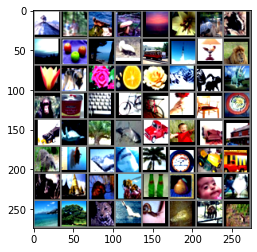

GroundTruth:  mountain forest  seal mushroom


In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

이제, 저장했던 모델을 불러오도록 하겠습니다 (주: 모델을 저장하고 다시 불러오는
작업은 여기에서는 불필요하지만, 어떻게 하는지 설명을 위해 해보겠습니다):



In [22]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

좋습니다, 이제 이 예제들을 신경망이 어떻게 예측했는지를 보겠습니다:



In [23]:
outputs = net(images)

출력은 100개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이
나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것입니다.
따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다:



In [24]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  dolphin rabbit crocodile trout




전체 데이터셋에 대해서는 어떻게 동작하는지 보겠습니다.



In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 35 %


100가지 분류 중 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보겠습니다:



In [26]:
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(100):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of apple : 100 %
Accuracy of aquarium_fish : 57 %
Accuracy of  baby : 16 %
Accuracy of  bear : 33 %
Accuracy of beaver :  0 %
Accuracy of   bed : 14 %
Accuracy of   bee : 50 %
Accuracy of beetle :  0 %
Accuracy of bicycle : 33 %
Accuracy of bottle : 50 %
Accuracy of  bowl : 25 %
Accuracy of   boy :  0 %
Accuracy of bridge : 33 %
Accuracy of   bus : 33 %
Accuracy of butterfly : 10 %
Accuracy of camel :  0 %
Accuracy of   can : 42 %
Accuracy of castle : 50 %
Accuracy of caterpillar : 42 %
Accuracy of cattle : 14 %
Accuracy of chair : 87 %
Accuracy of chimpanzee : 14 %
Accuracy of clock : 20 %
Accuracy of cloud : 33 %
Accuracy of cockroach : 50 %
Accuracy of couch : 40 %
Accuracy of  crab : 60 %
Accuracy of crocodile : 25 %
Accuracy of   cup : 20 %
Accuracy of dinosaur : 33 %
Accuracy of dolphin :  0 %
Accuracy of elephant : 28 %
Accuracy of flatfish : 33 %
Accuracy of forest : 50 %
Accuracy of   fox :  0 %
Accuracy of  girl :  0 %
Accuracy of hamster : 66 %
Accuracy of house : 4

ZeroDivisionError: ignored